In [1]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from torch.utils.data import Dataset, DataLoader
from PIL import Image

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


In [16]:
# run params
SECTION = 'gan'
RUN_ID = '0001'
DATA_NAME = 'camel'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

if not os.path.exists(RUN_FOLDER):
    os.mkdir(RUN_FOLDER)
    os.mkdir(os.path.join(RUN_FOLDER, 'viz'))
    os.mkdir(os.path.join(RUN_FOLDER, 'images'))
    os.mkdir(os.path.join(RUN_FOLDER, 'weights'))

mode =  'build' #'load' #

In [17]:
total = np.load(glob('data/camel/*')[0])

# train_size = int(len(total) * 0.8)
train, test = total[:80000], total[80000:]

In [18]:
class SimpleDataset(Dataset):
    def __init__(self, npy, transform):
        self.npy = npy
        self.transform = transform

    def __len__(self):
        return len(self.npy)

    def __getitem__(self, idx):
        img = self.npy[idx]
        if self.transform:
            img = (img.astype('float32') - 127.5) / 127.5
            img = img.reshape(28, 28, 1) 
            img = self.transform(img)
            
        return img

In [19]:
NUM_CLASSES = 10
BATCH_SIZE = 64
transform = transforms.Compose([   
    transforms.ToTensor()
])
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [20]:
train_dataset = SimpleDataset(train, transform)
test_dataset = SimpleDataset(test, transform)

train_dataloader = DataLoader(train_dataset, BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, BATCH_SIZE, shuffle=True)

In [21]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 64, 5, 2)
        self.dropout1 = nn.Dropout(0.4)

        self.conv2 = nn.Conv2d(64, 64, 5, 2)
        self.dropout2 = nn.Dropout(0.4)

        self.conv3 = nn.Conv2d(64, 128, 5, 2)
        self.dropout3 = nn.Dropout(0.4)

        self.conv4 = nn.Conv2d(128, 128, 5, 1)
        self.dropout4 = nn.Dropout(0.4)

        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(2048, 1)
    def forward(self, x):
        x = F.pad(self.conv1(x), (1,1,1,1))
        x = F.relu(x)
        x = self.dropout1(x)

        x = F.pad(self.conv2(x), (1,1,1,1))
        x = F.relu(x)
        x = self.dropout2(x)

        x = F.pad(self.conv3(x), (2,2,2,2))
        x = F.relu(x)
        x = self.dropout3(x)

        x = F.pad(self.conv4(x), (1,1,1,1))
        x = F.relu(x)
        x = self.dropout4(x)
        

        x = self.flatten(x)

        x = self.linear1(x)
        return torch.sigmoid(x)

In [22]:
Discriminator()(torch.randn(1, 1, 28, 28))

tensor([[0.4976]], grad_fn=<SigmoidBackward0>)

In [23]:
z_dim = 100
class Generator(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.linear1 = nn.Linear(z_dim, 3136)
        self.bn1 = nn.BatchNorm1d(3136, momentum=0.9)
        self.upsample1 = nn.UpsamplingNearest2d(scale_factor=2)

        self.conv1 = nn.Conv2d(64, 128, 5, 1)
        self.bn2 = nn.BatchNorm2d(128, momentum=0.9)
        self.upsample2 = nn.UpsamplingNearest2d(scale_factor=2)

        self.conv2 = nn.Conv2d(128, 64, 5, 1)
        self.bn3 = nn.BatchNorm2d(64, momentum=0.9)

        self.convT1 = nn.ConvTranspose2d(64, 64, 5, 1, 2)
        self.bn4 = nn.BatchNorm2d(64, momentum=0.9)

        self.convT2 = nn.ConvTranspose2d(64, 1, 5, 1, 2)

        
    def forward(self, x):
        x = self.bn1(self.linear1(x))
        x = F.relu(x)
        x = x.reshape(-1, 64, 7, 7)
        x = self.upsample1(x)
        x = F.pad(self.conv1(x), (2,2,2,2))
        x = self.bn2(x)
        x = F.relu(x)

        x = self.upsample2(x)
        x = F.pad(self.conv2(x), (2,2,2,2))
        x = F.relu(self.bn3(x))

        x = self.convT1(x)
        x = self.bn4(x)
        x = self.convT2(x)

        return torch.tanh(x)

In [24]:
discriminator = Discriminator().to(device)
generator =  Generator(100).to(device)
d_optimizer = optim.RMSprop(discriminator.parameters(),lr=0.0008)
g_optimizer = optim.RMSprop(generator.parameters(), lr=0.0004)
criterion = nn.BCELoss()

In [25]:
next(iter(train_dataloader)).shape

torch.Size([64, 1, 28, 28])

In [26]:
d_losses, g_losses = [], []
for epoch in range(200):  # loop over the dataset multiple times
    g_total, d_total = 0., 0.
    for i, inputs in enumerate(train_dataloader, 0):
        
        inputs = inputs.to(device)
        real = torch.ones((BATCH_SIZE, 1)).to(device)
        fake = torch.zeros((BATCH_SIZE, 1)).to(device)
        generator.eval()
        generated_images = generator(torch.randn((BATCH_SIZE, z_dim)).to(device))

        d_loss = criterion(discriminator(generated_images), fake)
        d_loss += criterion(discriminator(inputs), real)

        d_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()

        generator.train()
        discriminator.eval()
        real = torch.ones((BATCH_SIZE, 1)).to(device)
        generated_images = generator(torch.randn((BATCH_SIZE, z_dim)).to(device))

        g_loss = criterion(discriminator(generated_images), real)
        
        g_optimizer.zero_grad()
        g_loss.backward()
        g_optimizer.step()

        d_total += d_loss.item()
        g_total += g_loss.item()
    
    d_losses.append(d_total/len(train_dataloader))
    g_losses.append(g_total/len(train_dataloader))

    print(f'[{epoch + 1}] d_loss: {d_total / len(train_dataloader):.3f} g_loss: {g_total / len(train_dataloader):.3f}')
    torch.save(discriminator, RUN_FOLDER + "/weights/discriminator.pt")
    torch.save(generator, RUN_FOLDER + "/weights/generator.pt")


print('Finished Training')

[1] d_loss: 0.842 g_loss: 5.862
[2] d_loss: 0.750 g_loss: 1.939
[3] d_loss: 0.620 g_loss: 2.296
[4] d_loss: 0.551 g_loss: 2.546
[5] d_loss: 0.515 g_loss: 2.752
[6] d_loss: 0.484 g_loss: 2.913
[7] d_loss: 0.466 g_loss: 3.038
[8] d_loss: 0.466 g_loss: 3.120
[9] d_loss: 0.457 g_loss: 3.241
[10] d_loss: 0.439 g_loss: 3.425
[11] d_loss: 0.428 g_loss: 3.558
[12] d_loss: 0.418 g_loss: 3.694
[13] d_loss: 0.405 g_loss: 3.852
[14] d_loss: 0.391 g_loss: 4.003
[15] d_loss: 0.385 g_loss: 4.164
[16] d_loss: 0.381 g_loss: 4.254
[17] d_loss: 0.365 g_loss: 4.451
[18] d_loss: 0.359 g_loss: 4.583
[19] d_loss: 0.350 g_loss: 4.825
[20] d_loss: 0.347 g_loss: 5.031
[21] d_loss: 0.341 g_loss: 5.211
[22] d_loss: 0.329 g_loss: 5.435
[23] d_loss: 0.333 g_loss: 5.506
[24] d_loss: 0.319 g_loss: 5.744
[25] d_loss: 0.314 g_loss: 5.805
[26] d_loss: 0.313 g_loss: 6.027
[27] d_loss: 0.301 g_loss: 6.189
[28] d_loss: 0.304 g_loss: 6.325
[29] d_loss: 0.301 g_loss: 6.473
[30] d_loss: 0.288 g_loss: 6.732
[31] d_loss: 0.294 

KeyboardInterrupt: 

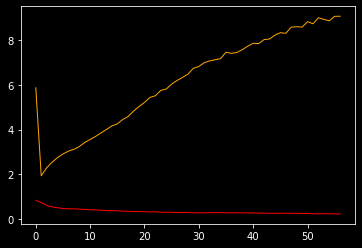

In [30]:
fig = plt.figure()
plt.plot([x for x in d_losses], color='red', linewidth=1)

plt.plot([y for y in g_losses], color='orange', linewidth=1)

plt.show()


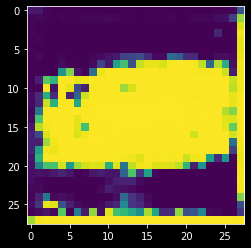

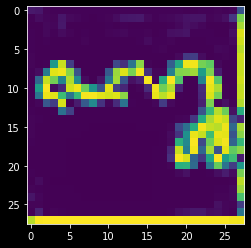

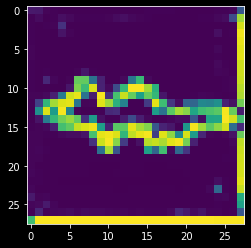

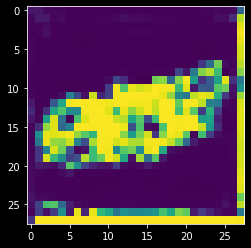

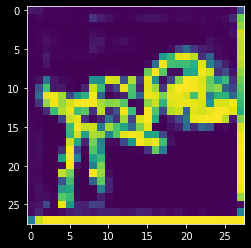

In [48]:
generator.eval()
transform1 = transforms.ToPILImage()

noise = torch.randn(5, 100).to(device)

for i in range(noise.shape[0]):
    plt.imshow(transform1(generator(noise[i].unsqueeze(0))[0]))
    plt.show()